## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

In [2]:
# Imports 

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### First, I'll compute the camera calibration using chessboard images

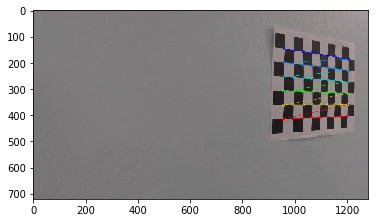

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img);

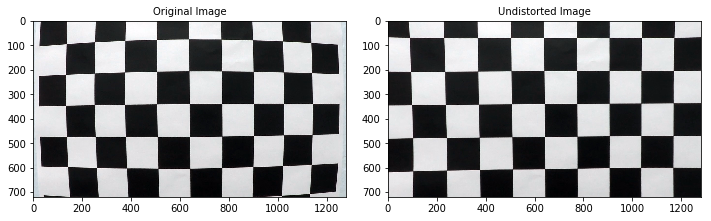

In [4]:
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img, objpoints, imgpoints)

f, ax = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax[0].imshow(img);
ax[0].set_title('Original Image', fontsize=10);

ax[1].imshow(undistorted);
ax[1].set_title('Undistorted Image', fontsize=10);

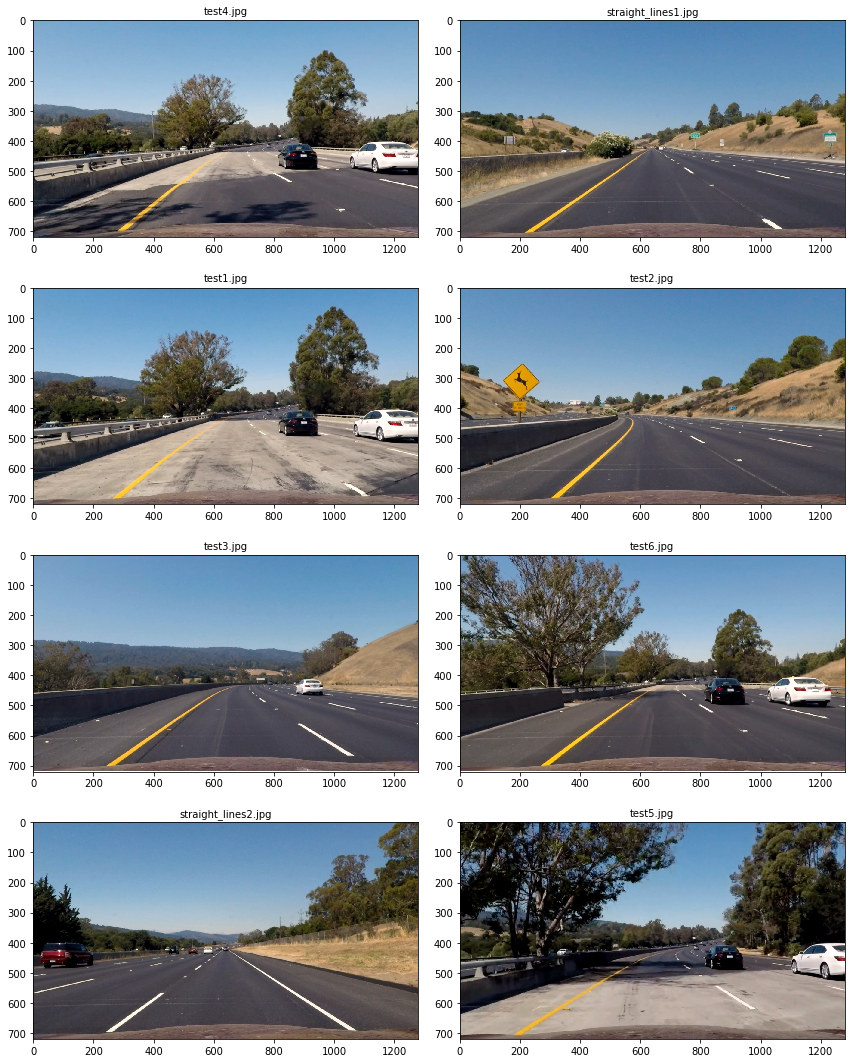

In [5]:
# Test Images
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(4, 2, figsize=(12, 15));
f.tight_layout()

images = []
undistorted_images = []
ax1, ax2 = 0, 0
for fname in test_images:
    img = cv2.cvtColor( cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    images.append(img)
    
    undist = undistort(img, objpoints, imgpoints)
    undistorted_images.append( undist )
    
    ax[ax1, ax2].imshow( undist )
    ax[ax1, ax2].set_title(fname.split('/')[1], fontsize=10)
        
    if ax2==1:
        ax2=0
        ax1+=1
    else:
        ax2+=1

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [369]:
# Thresholding Functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255) ):
    # Apply the following steps to img
    # 1) Receive 1chanel img    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary#np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelX**2 + sobelY**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelMag/np.max(sobelMag))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    
    return binary_output


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelX = np.absolute(sobelX)
    abs_sobelY = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobelY, abs_sobelX)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(dir)
    sxbinary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

def gradient_threshold(img, ksize=3):
    """Applies sobel thresholds and returns a combined image"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 150))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(35, 150))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 150))
    dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    
def color_thresh(img, thresh=(0, 255), thresh2=(0, 255)):
    """Filter color from an RGB image"""
    R = img[:,:,0]

    HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    HLS_S = HLS[:,:,2]

    binary = np.zeros_like(R)
    binary[((R>=thresh[0])&(R<=thresh[1])) | ((HLS_S>=thresh2[0])&(HLS_S<=thresh2[1])) ] = 1
    return binary

def threshold(img):
    """Combines Gradient and Color thresholds"""
    # Gradient Threshold
    gradient_binary = gradient_threshold(img, ksize=5)
    
    # Color Treshold
    color_binary = color_thresh(img, (220, 255), (150,254))

    #Combine color and gradient threshold
    color_grad_thresh = np.zeros_like(gradient_binary)
    color_grad_thresh[(gradient_binary==1)|(color_binary==1)] = 1 
    
    return color_grad_thresh

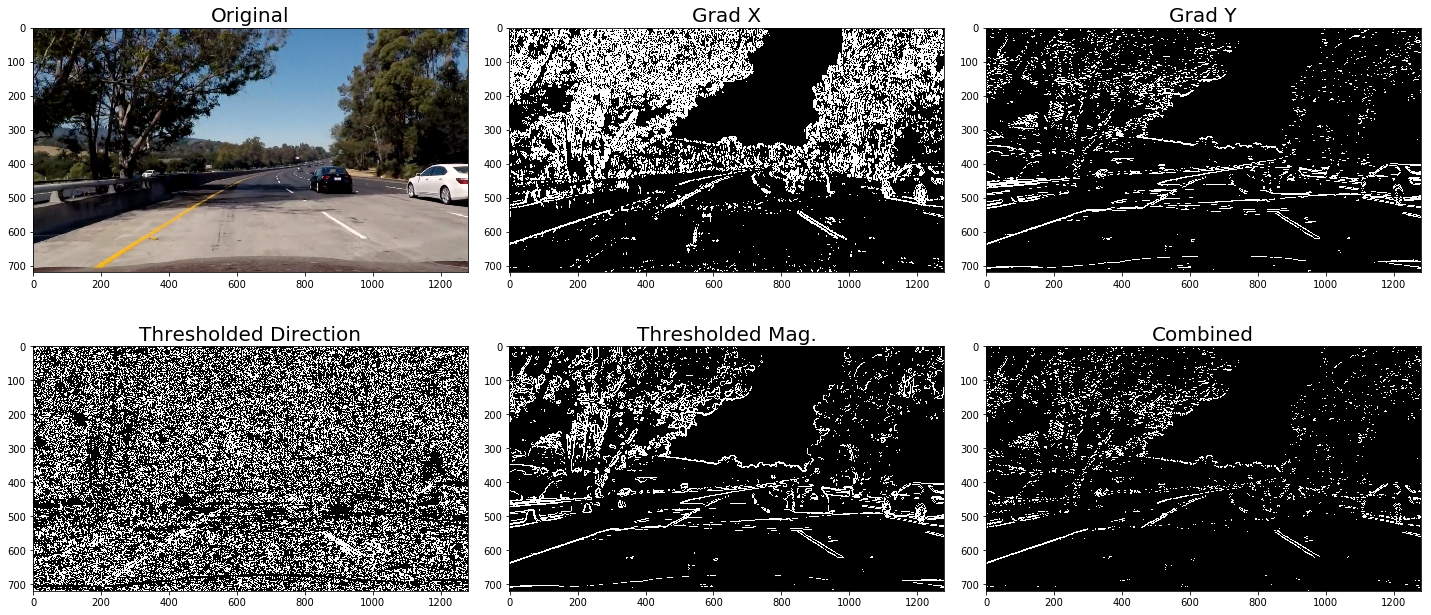

In [370]:
# Gradient treshold test

#image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
image = undistorted_images[7]
sobel_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#sobel_img = sobel_img[:,:,2]

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(sobel_img, orient='x', sobel_kernel=ksize, thresh=(10, 150))
grady = abs_sobel_thresh(sobel_img, orient='y', sobel_kernel=ksize, thresh=(35, 150))

mag_binary = mag_thresh(sobel_img, sobel_kernel=ksize, mag_thresh=(40, 150))
dir_binary = dir_thresh(sobel_img, sobel_kernel=ksize, thresh=(.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (grady == 1))] = 1
#combined[((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, ax = plt.subplots(2, 3, figsize=(20, 9))
f.tight_layout()

ax[0,0].imshow( image );
ax[0,0].set_title('Original', fontsize=20);

ax[0,1].imshow(gradx, cmap='gray');
ax[0,1].set_title('Grad X', fontsize=20);

ax[0,2].imshow(grady, cmap='gray');
ax[0,2].set_title('Grad Y', fontsize=20);

ax[1,0].imshow(dir_binary, cmap='gray');
ax[1,0].set_title('Thresholded Direction', fontsize=20);

ax[1,1].imshow(mag_binary, cmap='gray');
ax[1,1].set_title('Thresholded Mag.', fontsize=20);

ax[1,2].imshow(combined, cmap='gray');
ax[1,2].set_title('Combined', fontsize=20);

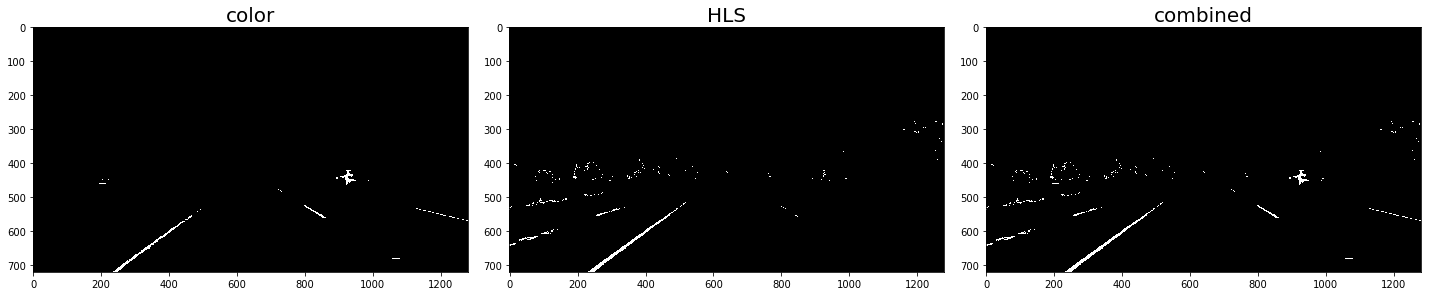

In [374]:
# Color threshold test
image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
#image = undistorted_images[7]

R = image[:,:,0]
color = np.zeros_like(R)
color[(R>=220)&(R<=255)] = 1

HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
HLS_S = HLS[:,:,2]
S_bin = np.zeros_like(HLS_S)
S_bin[(HLS_S>=150)&(HLS_S<=254)] = 1

f, ax = plt.subplots(1, 3, figsize=(20, 9))
f.tight_layout()

ax[0].imshow( color, cmap="gray" );
ax[0].set_title('color', fontsize=20);

ax[1].imshow( S_bin, cmap="gray" );
ax[1].set_title('HLS', fontsize=20);

ax[2].imshow( color_thresh(image, (220, 255), (150,254)), cmap="gray" );
ax[2].set_title('combined', fontsize=20);

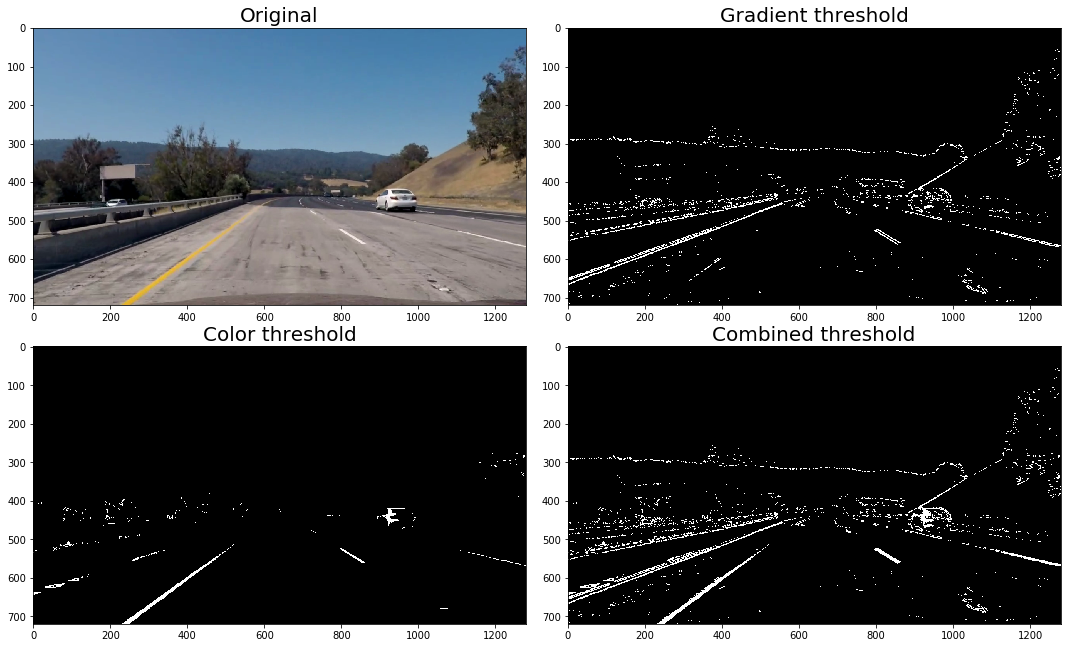

In [375]:
# Threshold final result

image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
#image = undistorted_images[7]

f, ax = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax[0,0].imshow( image );
ax[0,0].set_title('Original', fontsize=20);

ax[0,1].imshow(gradient_threshold(image, ksize=5), cmap='gray');
ax[0,1].set_title('Gradient threshold', fontsize=20);

ax[1,0].imshow(color_thresh(image, (220, 255), (150,254)), cmap='gray');
ax[1,0].set_title('Color threshold', fontsize=20);

ax[1,1].imshow(threshold(image), cmap='gray');
ax[1,1].set_title('Combined threshold', fontsize=20);

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [397]:
# Transformation matrix and functions
src = np.float32(
    [[700, 460],
     [1000, 680],
     [300, 680],
     [580, 460]])

dst = np.float32(
    [[980, 0],
     [950, 720],
     [350, 720],
     [320, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    
def warp(img, inverse=False):
    img_size = (img.shape[1], img.shape[0])
    
    if inverse:
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped

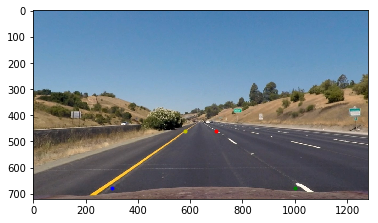

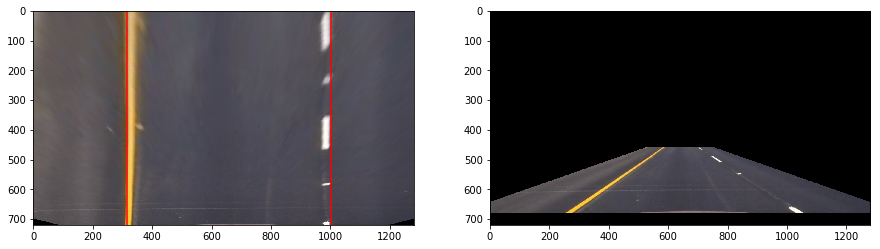

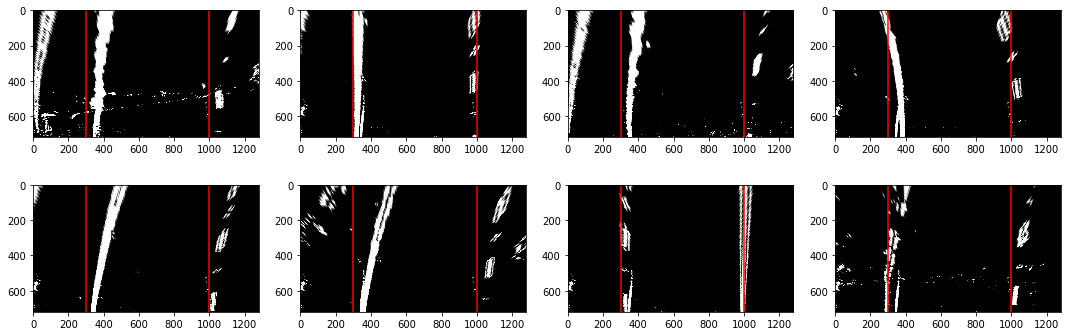

In [400]:
# test warped images
img = undistorted_images[1]

warped = warp(img)
unwarped = warp(warped, True)

plt.imshow( img )
plt.plot(src[0][0],src[0][1], '.r');
plt.plot(src[1][0],src[1][1], '.g');
plt.plot(src[2][0],src[2][1], '.b');
plt.plot(src[3][0],src[3][1], '.y');

f, ax = plt.subplots(1, 2, figsize=(15, 5));
ax[0].imshow( warped );
ax[0].plot([1002, 1002],[0,719], 'r-');
ax[0].plot([317, 317],[0,719], 'r-');

ax[1].imshow( unwarped );

warped_images = []

f, ax = plt.subplots(2, 4, figsize=(15, 5));
f.tight_layout()

row, col = 0, 0
for img in undistorted_images:
    warped = warp(threshold(img))
    warped_images.append(warped)
    ax[row,col].imshow( warped, cmap="gray" );
    ax[row,col].plot([1000, 1000],[0,719], 'r-');
    ax[row,col].plot([300, 300],[0,719], 'r-');
       
    col+=1
    if col==4:
        col=0
        row+=1

### Detect lane pixels and fit to find the lane boundary.

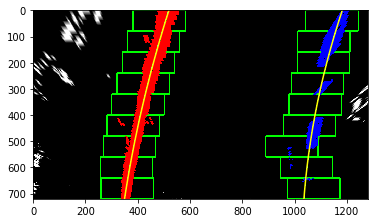

In [410]:
binary_warped = warped_images[5]

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
        
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Color each side
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

binary_warped = warped_images[5]
#left_fit, right_fit, out_img = detect_lines(binary_warped)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

pts = np.array(list(zip(left_fitx, ploty)), np.int32)
cv2.polylines(out_img,[pts],False,(0,255,255), 2, lineType=8)

pts2 = np.array(list(zip(right_fitx, ploty)), np.int32)
cv2.polylines(out_img,[pts2],False,(0,255,255), 2, lineType=8)

plt.imshow(out_img.astype(np.uint8));

plt.plot(left_fitx, ploty, color='yellow');
plt.plot(right_fitx, ploty, color='yellow');
plt.xlim(0, 1280);
plt.ylim(720, 0);